# Model Selection

We want real-time inference and have very little data to work with, so we will select a pre-trained MobileNet_V2 as a model for image classification. 

In [2]:
import torch
import torchvision

mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True, progress=True)
torch.cuda.is_available()

## Image preprocessing

Since the objective is image classification using a model that was pre-trained on ImageNet, we will use the following transformations:
- resize each image to (256, 256)
- Normalize to ImageNet mean and std
- Centering and Cropping the image
- 50% horizontal flip


In [3]:
from torchvision import transforms as T
from torchvision import datasets

def data_transformers(split:str):
    # using ImageNet mean and standard deviations to normalize images
    mu = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # training images will be randomly cropped and horizontally flipped
    # validation images will only be normalized
    data_transforms = {'train': T.Compose([
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(), # image is scaled to [0-1]
        T.Normalize(mu, std)
        ]),
        'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mu, std)
        ])}
    return data_transforms[split]

train_trans = data_transformers('train')
val_trans = data_transformers('val')

## Dataset V2

The original dataset was restructured to make use of native pytorch helper functions. As a result, the the labels files are no longer needed and images are placed in the following directory structure:
- dataset_v2
    - train
        - emergency
        - non-emergency
    - val
        - emergency
        - non-emergency

Due to the way Pytorch reads directories, the classes are assigned differently.

- 0 = emergency
- 1 = non-emergency

This is significant, because that changes the way we evaluate the model. The binary indicator for non-emergency vehicles is 1. The assumed priority is the 0 class, meaning that the metric of interest if our goal is to maximize the detection of emergency vehicles will be recall rather than precision.

The model's outputs are logits, and once exponentiated, represent the estimated likelihood that an object is a non-emergency vehicle. The conversion we can apply to change the exponentiated output is (1 - x) * 100 


In [4]:
import os

data_dir = '/home/ubuntu/datasets/Emergency_Vehicles/dataset_v2/'
batch_size = 16
tset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_trans)
vset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_trans)
dsets = {'train': tset, 'val': vset}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=25)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

for k,v in dset_sizes.items():
    print(k, v)
print(dset_classes)
print('number of batches in each data loader')
for k,v in dset_loaders.items():
    print(k,len(v))

train 1495
val 151
['emergency', 'non-emergency']
number of batches in each data loader
train 94
val 10


In [46]:
from time import time
import copy


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def train_model(model, dataloaders:dict(), criterion, optimizer, lr_scheduler, num_epochs=2):
    since = time()
    metrics = ['loss', 'accuracy', 'precision','recall','f1']
    val_history = {x:list() for x in metrics}
    train_history = {x:list() for x in metrics}

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                # optimizer = lr_scheduler(optimizer, epoch)
                model.train().to(device)
            else:
                model.eval().to(device)

            running_loss = 0.0
            running_corrects = 0
            tp = 0; fp = 0; tn = 0; fn = 0 

            for imgs, labels in dataloaders[phase]:

                imgs = imgs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase  == 'train'):
                    outputs = model(imgs)
                    loss = criterion(outputs.double(), labels.unsqueeze(1).double())
                    preds = torch.clip(outputs, 0, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds.squeeze(1) == labels.data.to(device), dim=0)
                for pred, truth in zip (preds.squeeze(1), labels.data.to(device)):
                    if truth == 1.0 and pred >= 1.0:
                        tp += 1
                    elif truth == 1.0 and pred < 1.0:
                        fn += 1
                    elif truth == 0.0 and pred >= 1.0:
                        fp += 1
                    elif truth == 0.0 and pred < 1.0:
                        tn += 1
                        
            scheduler.step()
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_precision = tp / (tp + fp)
            epoch_recall = tp / (tp + fn)
            epoch_f1 = 2 / ((1 / epoch_precision) + (1 / epoch_recall))
            values = [epoch_loss, epoch_acc, epoch_precision, epoch_recall, epoch_f1]
            if phase == 'train':
                for k,v in zip(metrics, values):
                    train_history[k].append(v)
            else:
                for k,v in zip(metrics, values):
                    val_history[k].append(v)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_acc = epoch_acc
                best_f1 = epoch_f1
                best_model = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print(f'Best val Acc: {best_acc:4f} \nBest val F1: {best_f1:4f}')

    # load best model weights
    model.load_state_dict(best_model)
    return model, {'train':train_history, 'val':val_history}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), .0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = .9)
criterion = torch.nn.BCEWithLogitsLoss()
mobilenet_v2.classifier = torch.nn.Linear(1280, 1)
outputs = train_model(mobilenet_v2, dset_loaders, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.1613 Acc: 0.8883 F1: 0.9195
val Loss: 0.1486 Acc: 0.9404 F1: 0.9617

Epoch 1/19
----------
train Loss: 0.0887 Acc: 0.9478 F1: 0.9621
val Loss: 0.1934 Acc: 0.9404 F1: 0.9508

Epoch 2/19
----------
train Loss: 0.0992 Acc: 0.9505 F1: 0.9648
val Loss: 0.1559 Acc: 0.9404 F1: 0.9556

Epoch 3/19
----------
train Loss: 0.1024 Acc: 0.9431 F1: 0.9600
val Loss: 0.1431 Acc: 0.9470 F1: 0.9565

Epoch 4/19
----------
train Loss: 0.0642 Acc: 0.9645 F1: 0.9803
val Loss: 0.1584 Acc: 0.9404 F1: 0.9560

Epoch 5/19
----------
train Loss: 0.0676 Acc: 0.9619 F1: 0.9733
val Loss: 0.1773 Acc: 0.9536 F1: 0.9617

Epoch 6/19
----------
train Loss: 0.0709 Acc: 0.9612 F1: 0.9697
val Loss: 0.1511 Acc: 0.9470 F1: 0.9565

Epoch 7/19
----------
train Loss: 0.0647 Acc: 0.9652 F1: 0.9756
val Loss: 0.1708 Acc: 0.9470 F1: 0.9565

Epoch 8/19
----------
train Loss: 0.0586 Acc: 0.9679 F1: 0.9785
val Loss: 0.1568 Acc: 0.9470 F1: 0.9617

Epoch 9/19
----------
train Loss: 0.0580 Acc: 0.9605 F1

## Save and Reload Model

In [59]:
torch.save(outputs[0].state_dict(), './emergency_vehicle_1_mobilenetv2.pth')

model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier = torch.nn.Linear(1280, 1)
model.load_state_dict(torch.load('./emergency_vehicle_1_mobilenetv2.pth'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Model Validation

In [124]:
imgs, labels = next(iter(dset_loaders['val']))

print(imgs.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


### Sample from the Validation Set

These randomly selected images are from the validation set. For presentation purposes, I am partially reversing the normalization procedure.

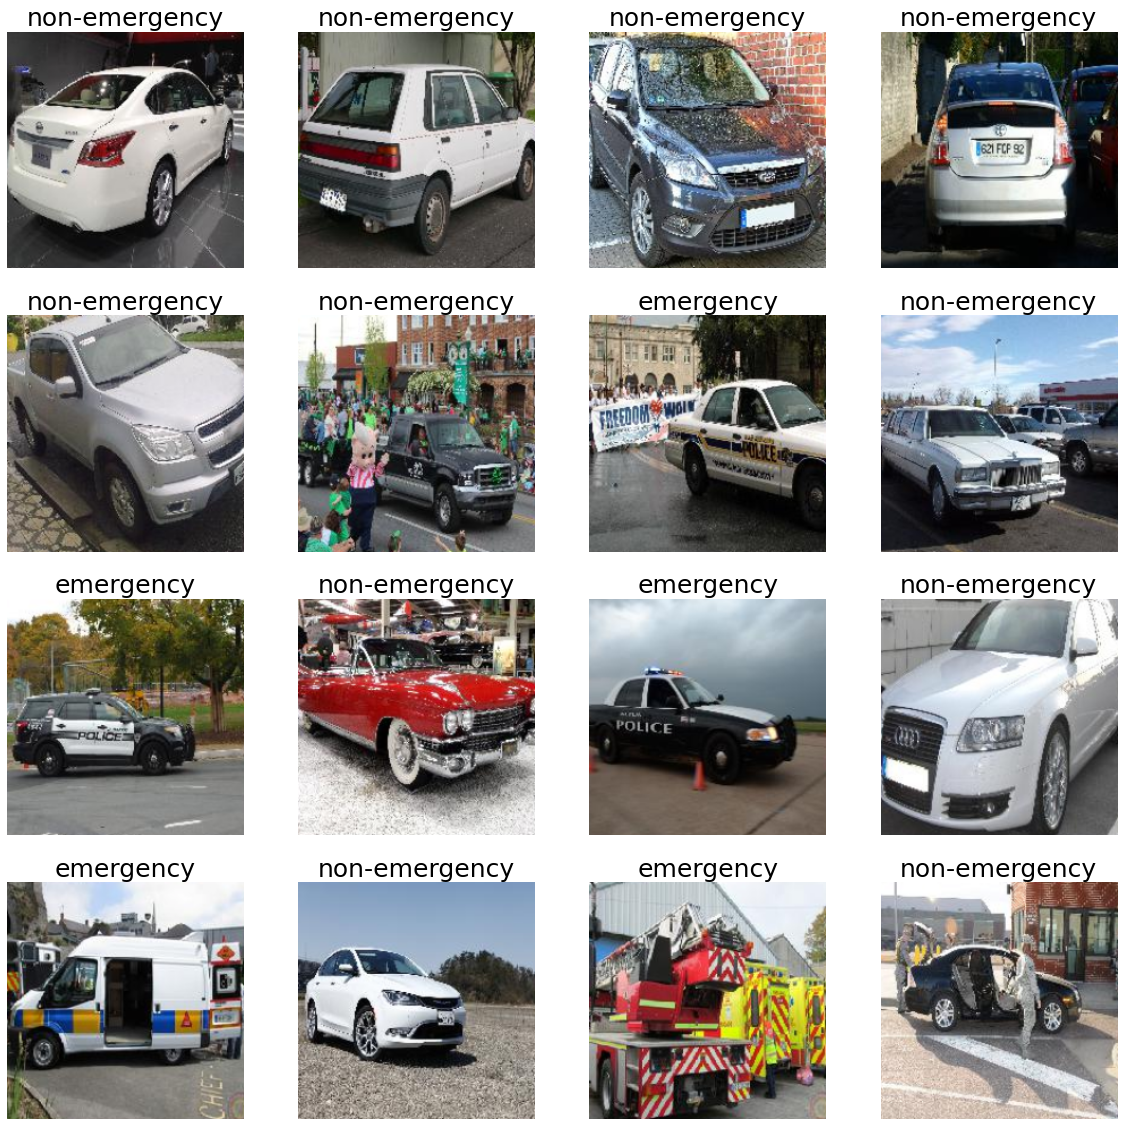

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def inverseNorm(img):
    std = [0.229, 0.224, 0.225]
    mu = [0.485, 0.456, 0.406]
    # pytorch functions that stop in-place operations
    img = img.detach().clone()
    # inverse norm operations
    for idx in range(3):
        img[idx,:,:] = img[idx,:,:] * std[idx]
        img[idx,:,:] = img[idx,:,:] + mu[idx]
    return img.numpy()

label_map = {1:'non-emergency', 0:'emergency'}
plt.figure(figsize=(20,20))
for idx, (im, lab) in enumerate(zip(imgs, labels)):
    im = inverseNorm(im)
    im = np.moveaxis(im, 0, -1)
    plt.subplot(4,4,idx + 1)
    plt.imshow(im)
    plt.title(label_map[int(lab.numpy())], fontdict={'fontsize':25})
    plt.axis('off')

## Model Performance

The model correctly identified 100% of 16 images in this validation sample.

In [126]:
logits = model(imgs)
preds = torch.clip(logits, 0, 1)

correct = torch.sum(preds.squeeze(1) == labels.data, dim=0)
print(correct)

tensor(15)


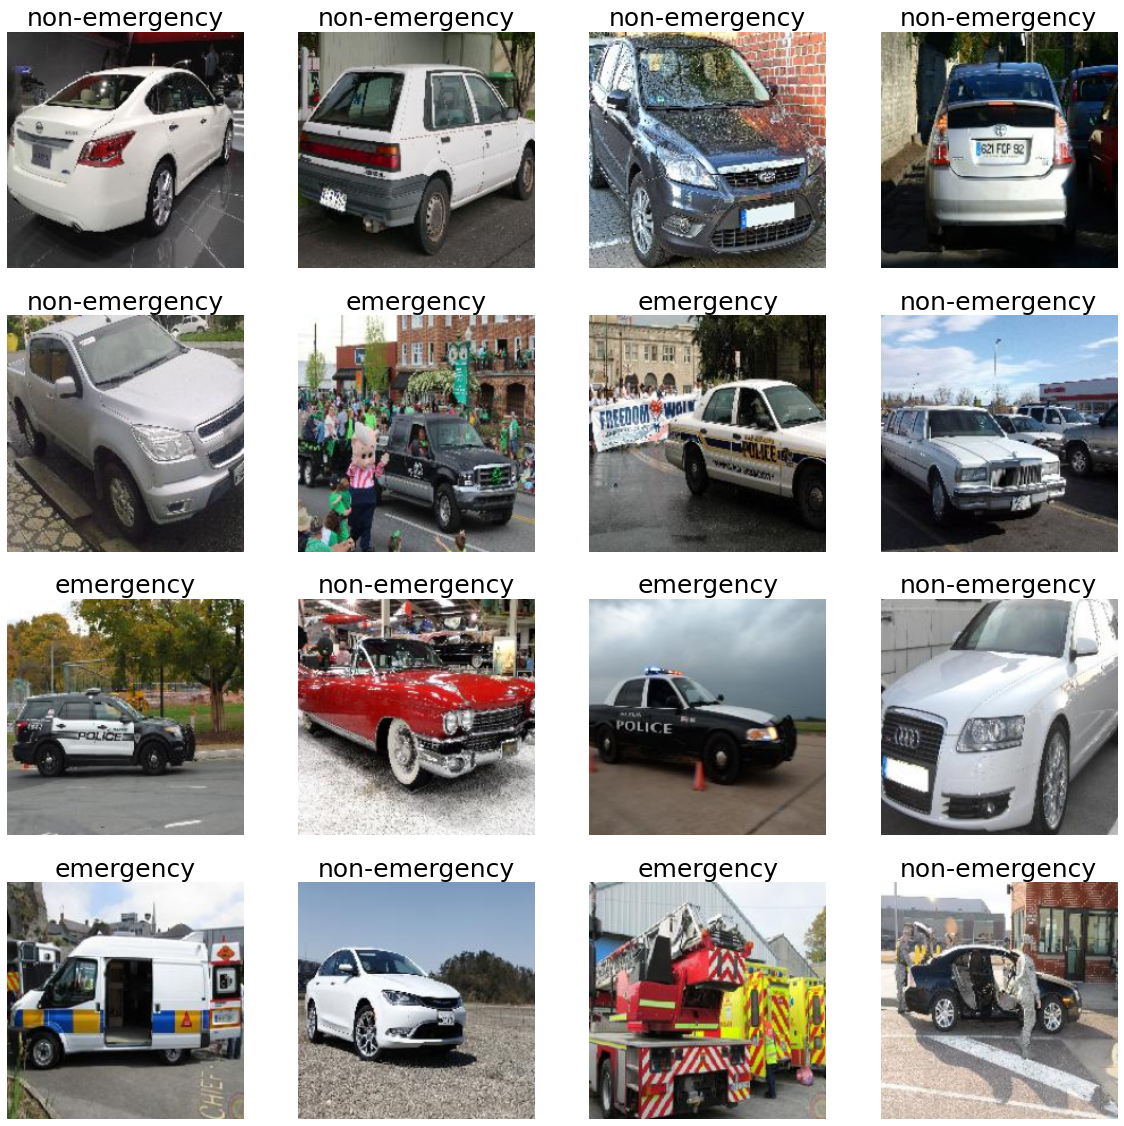

In [127]:
label_map = {1:'non-emergency', 0:'emergency'}
plt.figure(figsize=(20,20))
for idx, (im, lab) in enumerate(zip(imgs, preds)):
    im = inverseNorm(im)
    im = np.moveaxis(im, 0, -1)
    plt.subplot(4,4,idx + 1)
    plt.imshow(im)
    plt.title(label_map[int(lab.detach().numpy())], fontdict={'fontsize':25})
    plt.axis('off')